# Model Explainability Example

This notebook demonstrates how to use the `explainability` module to understand predictions from trained solar radiation forecasting models. It covers:
- **SHAP**: based on the Shapley values from game theory, which describe the contribution of each feature at each time step to the model's output.
  - **kernel**: model agnostic, by averaging over all possible feature combinations, but computationally expensive for large models.
  - **gradient**: Deep Learning-based, computationally efficient.
- **Sensitivity Analyzer**: alternative to SHAP, which based on the gradient of the model output with respect to the input features. This is customized for this coursework implementation to analyze temporal features as a whole (without looking at each time step individually).

To make our explainability more meaningful to GHI predictions, we will use the daytime predictions from the test set only, excluding the nighttime time steps (where GHI is mostly 0).

## 1. Imports and Setup

In [18]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 2
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from pathlib import Path
from torch.utils.data import DataLoader
from datetime import datetime

# Import project modules
from utils.explainer import ShapExplainer, SensitivityAnalyzer
from utils.timeseriesdataset import TimeSeriesDataset
from utils.model_utils import load_model
from utils.plot_utils import plot_predictions_over_time
from utils.data_persistence import load_scalers, load_normalized_data

# Configure plot style
plt.style.use('seaborn-v0_8-whitegrid')
# Timestamp the plot
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Set random seed
np.random.seed(42)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Configuration Parameters

Set the parameters for the explanation process. These correspond to the command-line arguments in the original script.
Change `SHAP_ALGORITHM` to `'kernel'` or `'gradient'` to use different SHAP algorithm.
This notebook uses `'gradient'` algorithm as default.

If you got Out of Memory (OOM) error, try to reduce `N_SAMPLES` to a smaller number.

In [19]:
# --- Configuration ---
MODEL_PATH = 'checkpoints/Mamba_best_20250507_231628.pt' # <<< --- IMPORTANT: Set path to your trained model file
SCALER_PATH = 'data/processed/scalers_20250430_145206.pkl' # <<< --- IMPORTANT: Set path to your scaler file
TRAIN_PREPROCESSED_DATA_PATH = 'data/processed/train_normalized_20250430_145157.h5' # <<< --- IMPORTANT: Set path to your train data file
TEST_PREPROCESSED_DATA_PATH = 'data/processed/test_normalized_20250430_145205.h5' # <<< --- IMPORTANT: Set path to your test data file
LOOKBACK = 24      # Lookback window used during model training
BATCH_SIZE = 64    # Batch size for data loading
N_SAMPLES = 400    # Number of explanation samples from the test set to use
BACKGROUND_SIZE = 20  # Number of background samples from the training set to use
OUTPUT_DIR = 'explainability' # Directory to save results
SHAP_ALGORITHM = 'gradient' # SHAP algorithm ('kernel' = model agnostic, 'gradient' = Deep Learning)
# ---

# Create output directory
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Model Path: {MODEL_PATH}")
print(f"Data Path: {TEST_PREPROCESSED_DATA_PATH}")
print(f"Output Directory: {output_dir}")


Model Path: checkpoints/Mamba_best_20250507_231628.pt
Data Path: data/processed/test_normalized_20250430_145205.h5
Output Directory: explainability


## 3. Load Data and Model

### 3.1 Load Model and Metadata

In [20]:
# Load model and metadata first
print(f"Loading model from {MODEL_PATH}...")
try:
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Let load_model handle the model class loading
    model, model_metadata = load_model(MODEL_PATH, device=device)
    print("Model loaded successfully.")

    # Ensure model is on the correct device
    model = model.to(device)
    # Make sure model is in training mode to enable gradient computation
    model.train()

    # Extract feature information from model metadata
    temporal_features = model_metadata.get('temporal_features', [])
    static_features = model_metadata.get('static_features', [])
    time_feature_keys = model_metadata.get('time_feature_keys', [])
    target_field = model_metadata.get('target_field', 'ghi')
    model_type = model_metadata.get('model_type', '')

    # Print model summary
    print("\n===== Model Summary =====")
    print(model)
    print("========================\n")

    # Check and print input size info from metadata
    input_size = model_metadata.get('input_size', None)
    hidden_size = model_metadata.get('hidden_size', None)
    print(f"Model type: {model_type}")
    print(f"Model input size from metadata: {input_size}")
    print(f"Model hidden size from metadata: {hidden_size}")
    print(f"Model expects time feature keys: {time_feature_keys}")
    print(f"Model expects temporal features: {temporal_features}")
    print(f"Model expects static features: {static_features}")
    print(f"Model target field: {target_field}")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}. Please check the path.")
    raise  # Re-raise the exception
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    raise

# Load data
print(f"Loading data from {TRAIN_PREPROCESSED_DATA_PATH}...")
try:
    train_data_dict, data_metadata = load_normalized_data(TRAIN_PREPROCESSED_DATA_PATH)

    nighttime_mask = train_data_dict.get('nighttime_mask')
    if nighttime_mask is None:
        print("Warning: 'nighttime_mask' not found in data. Cannot filter for daytime samples.")
        use_mask_filtering = False
    else:
        print(f"Loaded nighttime_mask with shape: {nighttime_mask.shape}")
        use_mask_filtering = True

    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Data file not found at {TRAIN_PREPROCESSED_DATA_PATH}. Please check the path.")
    raise # Re-raise the exception

# Prepare test dataset for explanations
print(f"Preparing test TimeSeriesDataset with lookback={LOOKBACK}...")
test_dataset = TimeSeriesDataset(
    preprocessed_data_path=TEST_PREPROCESSED_DATA_PATH,
    lookback=LOOKBACK,
    target_field=target_field,
    time_feature_keys=time_feature_keys,
    selected_features=temporal_features,
    static_features=static_features,
    lazy_loading=False,
    include_target_history=False
)

# Prepare train dataset for background data
print(f"Preparing train TimeSeriesDataset with lookback={LOOKBACK}...")
train_dataset = TimeSeriesDataset(
    preprocessed_data_path=TRAIN_PREPROCESSED_DATA_PATH,
    lookback=LOOKBACK,
    target_field=target_field,
    time_feature_keys=time_feature_keys,
    selected_features=temporal_features,
    static_features=static_features,
    lazy_loading=False,
    include_target_history=False
)

# Create a dataloader from the dataset
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoader created.")


Loading model from checkpoints/Mamba_best_20250507_231628.pt...
Using device: cuda
Dynamically imported model class: MambaModel from models.mamba
Model MambaModel requires parameters: ['input_dim', 'static_dim']
Model MambaModel optional parameters: ['d_model', 'd_state', 'n_layers', 'dt_rank', 'd_conv', 'expand_factor', 'dt_min', 'dt_max', 'dt_init', 'dt_scale', 'dropout']
Filtering out unexpected parameter: call_super_init
Filtering out unexpected parameter: dump_patches
Filtering out unexpected parameter: training
Creating model with parameters: {'d_conv': 4, 'd_model': 128, 'd_state': 16, 'dropout': 0.1, 'dt_init': 'random', 'dt_max': 0.1, 'dt_min': 0.001, 'dt_rank': 32, 'dt_scale': 1.0, 'expand_factor': 2, 'input_dim': 19, 'n_layers': 2, 'static_dim': 3}
Loaded MambaModel model from checkpoints/Mamba_best_20250507_231628.pt
  Saved date: 2025-05-07 23:16:28
  PyTorch version used for saving: 2.6.0+cu124
  Temporal features: hour_sin, hour_cos, day_sin, day_cos, month_sin, month_co

### 3.2 Visualize Model Predictions Over Time

Loaded 16 scalers from data/processed/scalers_20250430_145206.pkl
Generating predictions visualization...
Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


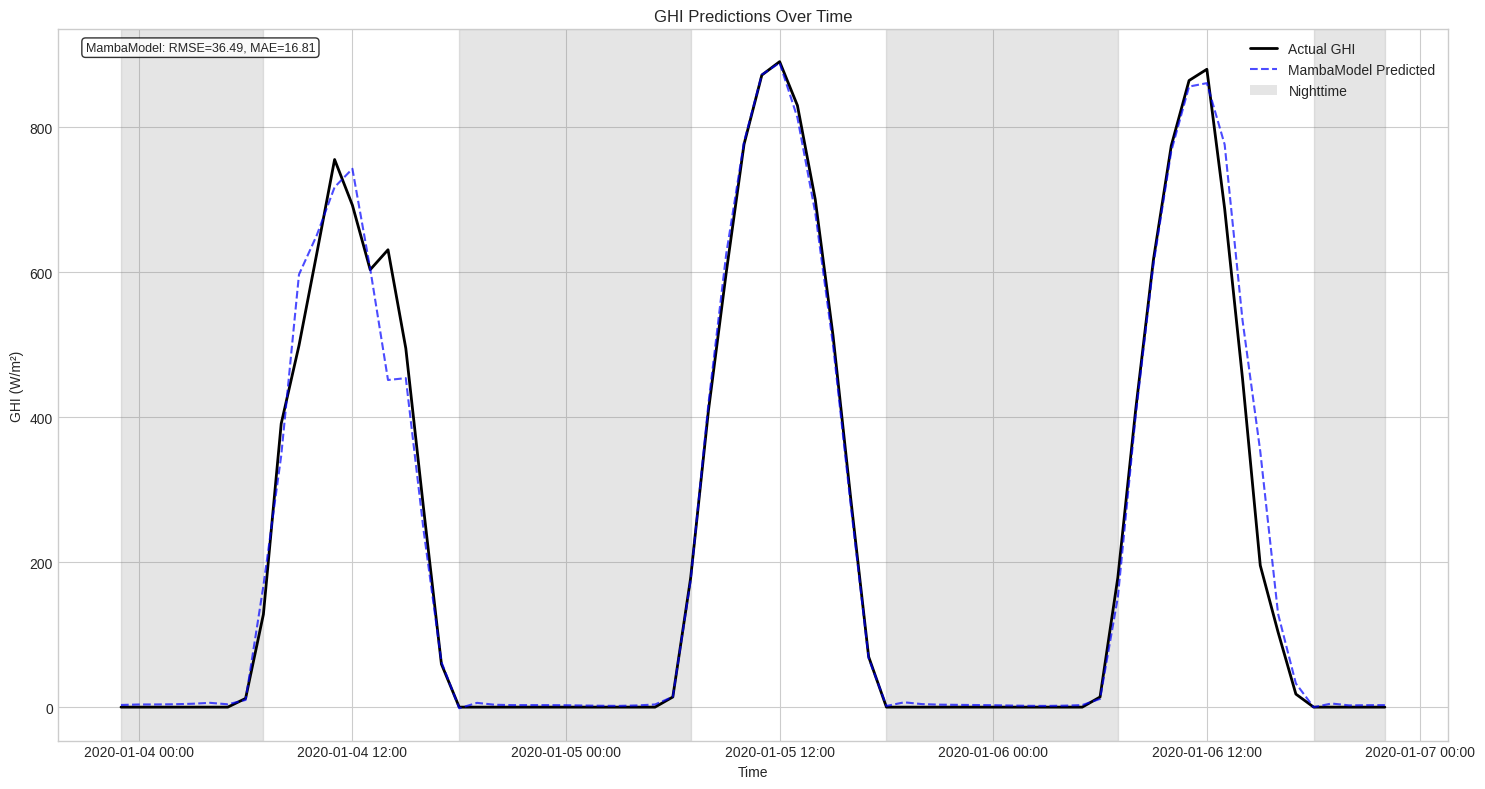

In [21]:
scaler = load_scalers(SCALER_PATH)
# Define target scaler from the data_metadata
target_scaler = scaler.get(f'{target_field}_scaler')
if target_scaler is None:
    print(f"Warning: No scaler found for target field '{target_field}'. Visualization may show scaled values.")

# Visualize the loaded model's predictions
print("Generating predictions visualization...")

# Create the visualization using the imported function
viz_fig = plot_predictions_over_time(
    models=[model],
    model_names=[model_type],
    data_loader=test_loader,
    target_scaler=target_scaler,
    num_samples=72,  # Adjust as needed
    start_idx=40       # Adjust as needed
)

# Display the plot if in a notebook environment
plt.show()


### 3.3 Check a Sample Batch

In [22]:
# Debug: Check a sample batch
batch = next(iter(test_loader))

# Check sample batch
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")
    elif isinstance(value, list):
        print(f"{key} length: {len(value)}")

# Extract dimensions from a batch (more reliable)
sample_temporal_features = batch['temporal_features']
sample_static_features = batch['static_features']
TEMPORAL_FEATURES_SHAPE = list(sample_temporal_features.shape)
STATIC_FEATURES_SHAPE = list(sample_static_features.shape)

# Check if we have 3D temporal features (batch, seq_len, features)
if len(sample_temporal_features.shape) == 3:
    temporal_dim = sample_temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = sample_temporal_features.shape[1]

static_dim = sample_static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Batch temporal_features shape: {TEMPORAL_FEATURES_SHAPE}")
print(f"  - Batch static_features shape: {STATIC_FEATURES_SHAPE}")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")


static_features shape: torch.Size([64, 3])
target shape: torch.Size([64])
temporal_features shape: torch.Size([64, 24, 19])
air_temperature shape: torch.Size([64, 24])
aod shape: torch.Size([64, 24])
cld_opd_dcomp shape: torch.Size([64, 24])
clearsky_ghi shape: torch.Size([64, 24])
cloud_type shape: torch.Size([64, 24])
nighttime_mask shape: torch.Size([64, 24])
relative_humidity shape: torch.Size([64, 24])
solar_zenith_angle shape: torch.Size([64, 24])
surface_albedo shape: torch.Size([64, 24])
total_precipitable_water shape: torch.Size([64, 24])
wind_speed shape: torch.Size([64, 24])
time_index_local length: 64
current_hour_sin shape: torch.Size([64])
current_hour_cos shape: torch.Size([64])
current_day_sin shape: torch.Size([64])
current_day_cos shape: torch.Size([64])
current_month_sin shape: torch.Size([64])
current_month_cos shape: torch.Size([64])
current_dow_sin shape: torch.Size([64])
current_dow_cos shape: torch.Size([64])
  Input dimensions determined from batch:
  - Batch t

## 4. Create Explainer

In [23]:
print(f"Creating explainer for model type: {model_type}...")
explainer = ShapExplainer(
    model=model,
    feature_names=temporal_features,
    static_feature_names=static_features
)
print(f"Explainer created: {type(explainer).__name__}")


Creating explainer for model type: MambaModel...
Explainer created: ShapExplainer


## 5. Prepare Background Data from Train Set and Samples from Test Set

We'll use the training data for background samples (SHAP baseline distribution) and test data for explanation samples.
This approach is more meaningful as it uses the distribution the model was trained on as the baseline.
Using the full training set can be computationally expensive, especially for methods like KernelSHAP,
so we select a subset of samples.

We also exclude nighttime samples from the background data as they are not valuable for GHI explanation.

In [24]:
# --- Prepare background data from TRAIN set ---
print("Preparing background data from TRAIN set...")
train_temporal_samples = []
train_static_samples = []

# Choose a subset of training samples for background data
train_indices = np.random.choice(len(train_dataset), min(BACKGROUND_SIZE, len(train_dataset)), replace=False)

# Extract samples from train dataset
for idx in train_indices:
    train_sample = train_dataset[idx]

    # Get temporal features
    x_temporal_tensor = train_sample.get('temporal_features')
    if isinstance(x_temporal_tensor, torch.Tensor):
        train_temporal_samples.append(x_temporal_tensor.cpu().numpy())
    else:
        train_temporal_samples.append(x_temporal_tensor)

    # Get static features
    x_static_tensor = train_sample.get('static_features')
    if isinstance(x_static_tensor, torch.Tensor):
        train_static_samples.append(x_static_tensor.cpu().numpy())
    else:
        train_static_samples.append(x_static_tensor)

# Stack collected numpy arrays for background data
train_temporal_array = np.stack(train_temporal_samples, axis=0)
train_static_array = np.stack(train_static_samples, axis=0)

print(f"Prepared {train_temporal_array.shape[0]} background samples from training data.")
print(f"Background temporal data shape: {train_temporal_array.shape}")
print(f"Background static data shape: {train_static_array.shape}")

# --- Prepare samples to explain from TEST set ---
print(f"Preparing {N_SAMPLES} samples for explanation from TEST set...")
X_temporal_samples = []
X_static_samples = []
y_samples = []

# Determine valid indices based on nighttime mask (if available)
if use_mask_filtering:
    print("Filtering samples using nighttime_mask...")
    # Assume mask shape aligns with n_timesteps, handle potential multi-location later if needed
    # We need the mask value at the *target* time step, which is `start_index + lookback`
    mask_for_targets = nighttime_mask[test_dataset.lookback:]

    # Valid start indices are those where the corresponding target mask is False (daytime)
    # Need to adjust indices based on potential multi-location structure if mask is 2D
    if len(nighttime_mask.shape) == 1:
        # Simple case: 1D mask (applies to all locations or single location)
        valid_dataset_indices = [idx for idx in range(len(test_dataset))
                                if not mask_for_targets[idx // test_dataset.n_locations]] # Get timestep index
    elif len(nighttime_mask.shape) == 2 and nighttime_mask.shape[1] == test_dataset.n_locations:
        # 2D mask (timesteps, locations)
        valid_dataset_indices = [idx for idx in range(len(test_dataset))
                                if not mask_for_targets[idx // test_dataset.n_locations, idx % test_dataset.n_locations]]
    else:
        print(f"Warning: Unexpected nighttime_mask shape {nighttime_mask.shape}. Proceeding without filtering.")
        valid_dataset_indices = list(range(len(test_dataset)))

    if not valid_dataset_indices:
        raise ValueError("Error: No daytime samples found after filtering with nighttime_mask.")
    print(f"Found {len(valid_dataset_indices)} valid daytime samples out of {len(test_dataset)} total.")
else:
    print("Skipping nighttime filtering (mask not available or disabled).")
    valid_dataset_indices = list(range(len(test_dataset)))

# Determine the number of samples to actually select
num_available = len(valid_dataset_indices)
num_to_select = min(N_SAMPLES, num_available)

if num_to_select <= 0:
    raise ValueError(f"Error: Cannot select {N_SAMPLES} samples. Only {num_available} valid samples available.")

print(f"Selecting {num_to_select} samples for explanation from {num_available} valid samples...")

# Randomly choose indices from the valid ones
selected_indices = np.random.choice(valid_dataset_indices, num_to_select, replace=False)

# Retrieve samples directly from the dataset using selected indices
for idx in selected_indices:
    sample = test_dataset[idx] # __getitem__ returns a dict

    # Ensure sample components are tensors before converting to numpy
    x_temporal_tensor = sample.get('temporal_features')
    x_static_tensor = sample.get('static_features')
    y_tensor = sample.get('target')

    # Convert tensors to numpy arrays (move to CPU first if on GPU)
    if isinstance(x_temporal_tensor, torch.Tensor):
        X_temporal_samples.append(x_temporal_tensor.cpu().numpy())
    else:
        X_temporal_samples.append(x_temporal_tensor) # Assume already numpy or compatible

    if isinstance(x_static_tensor, torch.Tensor):
        X_static_samples.append(x_static_tensor.cpu().numpy())
    else:
        X_static_samples.append(x_static_tensor)

    if isinstance(y_tensor, torch.Tensor):
        y_samples.append(y_tensor.cpu().numpy())
    else:
        y_samples.append(y_tensor)

# Stack collected numpy arrays
if not X_temporal_samples:
    print("Error: No samples collected after filtering and selection.")
else:
    X_temporal_array = np.stack(X_temporal_samples, axis=0)
    X_static_array = np.stack(X_static_samples, axis=0)
    y_array = np.stack(y_samples, axis=0)

    print(f"Prepared {X_temporal_array.shape[0]} samples from test data for explanation.")
    print(f"Test temporal data shape: {X_temporal_array.shape}")
    print(f"Test static data shape: {X_static_array.shape}")


Preparing background data from TRAIN set...
Prepared 20 background samples from training data.
Background temporal data shape: (20, 24, 19)
Background static data shape: (20, 3)
Preparing 400 samples for explanation from TEST set...
Filtering samples using nighttime_mask...
Found 458183 valid daytime samples out of 919800 total.
Selecting 400 samples for explanation from 458183 valid samples...
Prepared 400 samples from test data for explanation.
Test temporal data shape: (400, 24, 19)
Test static data shape: (400, 3)


## 6. Run SHAP Explanation and Visualize Results

### 6.1 SHAP Explanation - Feature Names Preparation

In [25]:
# Determine which explainer type we're using and proceed accordingly
print(f"--- Running SHAP Explanation ({SHAP_ALGORITHM}) ---")

# Print shapes for debugging
print(f"X_temporal_array shape: {X_temporal_array.shape}")
print(f"X_static_array shape: {X_static_array.shape}")

# Extract shape information for feature naming
batch_size, seq_len, n_features = X_temporal_array.shape
print(f"Detected shape: batch_size={batch_size}, seq_len={seq_len}, n_features={n_features}")

# Create meaningful feature names by combining temporal feature names with time steps
feature_names_flat = []
for t in range(seq_len):
    for feat_idx, feat_name in enumerate(temporal_features):
        # Create more descriptive feature names with time indices
        feature_names_flat.append(f"{feat_name}_t-{seq_len-1-t}")

# Add static feature names if available
if static_features is not None and len(static_features) > 0:
    feature_names_flat.extend(static_features)
    print(f"Added {len(static_features)} static features to feature_names_flat")

print(f"Created {len(feature_names_flat)} feature names")
# Calculate total number of features (temporal + static)
total_features = len(feature_names_flat)
print(f"Total number of features (temporal + static): {total_features}")


--- Running SHAP Explanation (gradient) ---
X_temporal_array shape: (400, 24, 19)
X_static_array shape: (400, 3)
Detected shape: batch_size=400, seq_len=24, n_features=19
Added 3 static features to feature_names_flat
Created 459 feature names
Total number of features (temporal + static): 459


### 6.2 SHAP Explanation - Background Data Preparation

In [26]:
# Use train data for background - no flattening needed since model forward handles this
X_temporal_bg = train_temporal_array
X_static_bg = train_static_array

# Create the proper tuple format expected by initialize_explainer
background_data = (X_temporal_bg, X_static_bg)

print(f"Initializing SHAP explainer with {SHAP_ALGORITHM} algorithm using {X_temporal_bg.shape[0]} background samples from TRAIN set...")
print(f"Background data temporal shape: {X_temporal_bg.shape}")
print(f"Background data static shape: {X_static_bg.shape}")


Initializing SHAP explainer with gradient algorithm using 20 background samples from TRAIN set...
Background data temporal shape: (20, 24, 19)
Background data static shape: (20, 3)


### 6.3 SHAP Explanation - Model Wrapper Setup
Define the custom model wrapper function that properly handles combined temporal and static features

In [27]:
def custom_model_wrapper(x_input, return_pytorch_tensor=False):
    """Custom wrapper for the model that handles combined temporal and static features.

    Args:
        x_input: Combined input data (temporal + static features), can be numpy array or PyTorch tensor
        return_pytorch_tensor: If True, return PyTorch tensor (for GradientExplainer),
                               otherwise return numpy array (for KernelExplainer)
    """
    # Handle both numpy arrays and PyTorch tensors as input
    if isinstance(x_input, torch.Tensor):
        x_combined = x_input
        is_pytorch_input = True
    else:
        # Ensure input is numpy array
        x_combined = np.asarray(x_input)
        is_pytorch_input = False

        # Add batch dimension if input is 1D (single instance)
        if x_combined.ndim == 1:
            x_combined = x_combined.reshape(1, -1)
            is_single_instance = True
        else:
            is_single_instance = False

        # Create a tensor from input
        x_combined = torch.tensor(x_combined, dtype=torch.float32).to(device)

    # Get shapes from global variables
    batch_size = x_combined.shape[0]
    n_temporal_features = len(temporal_features)
    seq_len = LOOKBACK
    n_static_features = len(static_features)

    # Calculate total number of elements in combined features
    total_temporal_elements = seq_len * n_temporal_features
    total_elements = total_temporal_elements + n_static_features

    # Validate input dimensions
    if x_combined.shape[1] != total_elements:
        raise ValueError(
            f"Input tensor dimension ({x_combined.shape[1]}) does not match expected "
            f"({total_temporal_elements} + {n_static_features} = {total_elements}). "
            f"Check LOOKBACK, temporal_features, and static_features."
        )

    # Split the combined input into temporal and static parts
    x_temporal_flat = x_combined[:, :total_temporal_elements]
    x_static = x_combined[:, total_temporal_elements:]

    # Reshape temporal features to 3D
    x_temporal = x_temporal_flat.reshape(batch_size, seq_len, n_temporal_features)

    # Forward pass through the model
    if return_pytorch_tensor:
        # For GradientExplainer mode - return tensor directly (with gradient tracking)
        # Explicitly ensure model is in training mode for LSTM with cuDNN
        model.train()
        outputs = model(x_temporal, x_static)
        # Ensure outputs have shape (batch_size, num_outputs)
        if len(outputs.shape) == 1:
            # If output is 1D (e.g., single output value per sample), add a dimension
            outputs = outputs.unsqueeze(1)  # Add a dimension to make it (batch_size, 1)
        return outputs
    else:
        # For KernelExplainer mode - return numpy array (no gradient tracking)
        with torch.no_grad():
            output = model(x_temporal, x_static)

        # Return numpy array
        result = output.cpu().numpy()

        # --- Ensure output is at least 1D for SHAP ---
        final_result = np.atleast_1d(result)

        # SHAP KernelExplainer expects shape (n_outputs,) for single instance explanations
        # or (batch_size, n_outputs) for batch explanations.
        return final_result

print("Updated custom model wrapper defined.")


Updated custom model wrapper defined.


### 6.4 SHAP Explanation - Prepare Explanation Data & Initialize Explainer

In [28]:
# --- 1. Prepare Data for Explanation ---
# Explain a subset of the samples (SHAP can be slow)
explain_size = min(N_SAMPLES, X_temporal_array.shape[0])
explain_indices = np.random.choice(X_temporal_array.shape[0], explain_size, replace=False)

# Get temporal data for explanation
X_temporal_explain = X_temporal_array[explain_indices]
print(f"Selected {explain_size} samples for explanation.")
print(f"Explanation temporal data shape: {X_temporal_explain.shape}")

# Get corresponding static data (if available)
X_static_explain = X_static_array[explain_indices]
print(f"Explanation static data shape: {X_static_explain.shape}")

# --- 2. Combine Temporal and Static Features for SHAP ---
# Flatten temporal data
batch_size, seq_len, n_features = X_temporal_explain.shape
X_temporal_flat = X_temporal_explain.reshape(batch_size, -1)

# Combine flattened temporal and static data
X_combined_explain = np.concatenate([X_temporal_flat, X_static_explain], axis=1)
print(f"Combined explanation data shape: {X_combined_explain.shape}")

# Similarly, combine background data
batch_size_bg, seq_len_bg, n_features_bg = X_temporal_bg.shape
X_temporal_bg_flat = X_temporal_bg.reshape(batch_size_bg, -1)
X_combined_bg = np.concatenate([X_temporal_bg_flat, X_static_bg], axis=1)
print(f"Combined background data shape: {X_combined_bg.shape}")

# --- 3. Set Wrapper & Initialize Explainer ---
print("Setting custom model wrapper...")
explainer.set_custom_model_wrapper(custom_model_wrapper)

# Initialize the explainer using the combined background data
print("Initializing explainer...")
explainer.initialize_explainer(X_combined_bg, algorithm=SHAP_ALGORITHM)
print("Explainer initialized.")


Selected 400 samples for explanation.
Explanation temporal data shape: (400, 24, 19)
Explanation static data shape: (400, 3)
Combined explanation data shape: (400, 459)
Combined background data shape: (20, 459)
Setting custom model wrapper...
Custom model wrapper set successfully.
Initializing explainer...
Using combined background data with shape (20, 459)
Using custom model wrapper for SHAP explainer
Using custom model wrapper with PyTorchModelWrapper for GradientExplainer
Initializing GradientExplainer with PyTorchModelWrapper. Background data shape: torch.Size([20, 459])
Explainer initialized.


### 6.5 SHAP Explanation - Calculate SHAP Values

In [29]:
# Use the combined explanation data created in the previous cell
print(f"Calculating SHAP values for {explain_size} samples... (This might take a while)")

# Calculate SHAP values using the combined data
shap_values = explainer.explain_batch(X_combined_explain)
print(f"SHAP values calculated. SHAP values shape: {shap_values.shape}")

# When preparing for visualization, we'll need to separate the SHAP values for temporal and static features
n_temporal_elements = seq_len * n_features
n_static_elements = X_static_explain.shape[1]

# Split SHAP values into temporal and static parts if needed for visualization
if shap_values.shape[1] == n_temporal_elements + n_static_elements:
    print("Splitting SHAP values into temporal and static components for visualization...")
    temporal_shap_values = shap_values[:, :n_temporal_elements]
    static_shap_values = shap_values[:, n_temporal_elements:]
    print(f"Temporal SHAP values shape: {temporal_shap_values.shape}")
    print(f"Static SHAP values shape: {static_shap_values.shape}")
else:
    print(f"Warning: SHAP values shape {shap_values.shape} doesn't match expected combined dimension {n_temporal_elements + n_static_elements}")
    temporal_shap_values = shap_values
    static_shap_values = None


Calculating SHAP values for 400 samples... (This might take a while)
Using combined data with shape (400, 459)
Input tensor shape for explainer: torch.Size([400, 459])
Using algorithm: gradient
Calling GradientExplainer.shap_values...
Final SHAP values shape: (400, 459, 1)
SHAP values calculated. SHAP values shape: (400, 459, 1)
Splitting SHAP values into temporal and static components for visualization...
Temporal SHAP values shape: (400, 456, 1)
Static SHAP values shape: (400, 3, 1)


### 6.6 SHAP Explanation - Prepare Visualization Data

In [30]:
# For visualization, prepare feature names for both temporal and static features
print("Preparing visualization data...")

# Verify we have the correct feature names
print(f"Number of temporal features: {len(temporal_features)}")
print(f"Number of static features: {len(static_features or [])}")
print(f"Total number of feature names: {len(feature_names_flat)}")

# For visualization, we'll use the flattened temporal data and static data
X_flat_for_viz = X_combined_explain
shap_values_for_viz = shap_values

# Verify dimensions match between data and feature names
if len(feature_names_flat) != X_flat_for_viz.shape[1]:
    print(f"Warning: Mismatch between feature names ({len(feature_names_flat)}) and data dimension ({X_flat_for_viz.shape[1]})")

    # Calculate expected feature counts
    temporal_features_count = len(temporal_features) * seq_len
    static_features_count = len(static_features or [])
    expected_total = temporal_features_count + static_features_count
    print(f"Expected feature breakdown: {temporal_features_count} temporal + {static_features_count} static = {expected_total}")

    # Adjust feature names list if needed
    if len(feature_names_flat) > X_flat_for_viz.shape[1]:
        print(f"Truncating feature names from {len(feature_names_flat)} to {X_flat_for_viz.shape[1]}")
        feature_names_flat = feature_names_flat[:X_flat_for_viz.shape[1]]
    else:
        # If we have fewer feature names than columns, add generic names for the rest
        print(f"Adding generic names for missing features")
        for i in range(len(feature_names_flat), X_flat_for_viz.shape[1]):
            feature_names_flat.append(f'feature_{i}')

# For 3D visualizations (if needed later)
# For gradient algorithm, try to reshape temporal SHAP values back to 3D
try:
    n_temporal_elements = seq_len * len(temporal_features)
    if shap_values.shape[1] >= n_temporal_elements:
        # Extract just the temporal part of SHAP values
        temporal_shap_values = shap_values[:, :n_temporal_elements]
        explain_size = temporal_shap_values.shape[0]
        # Reshape temporal part to 3D
        shap_values_3d = temporal_shap_values.reshape(explain_size, seq_len, len(temporal_features))
        X_3d = X_temporal_explain
        print(f"Reshaped temporal SHAP values to 3D: {shap_values_3d.shape}")

        # If static features exist, extract their SHAP values too
        if len(static_features or []) > 0:
            static_shap_values = shap_values[:, n_temporal_elements:]
            print(f"Static SHAP values shape: {static_shap_values.shape}")
    else:
        print(f"Warning: SHAP values shape {shap_values.shape} doesn't have enough elements for temporal reshaping")
        shap_values_3d = None
        X_3d = None
except Exception as e:
    print(f"Could not reshape temporal SHAP values to 3D: {e}")
    shap_values_3d = None
    X_3d = None


Preparing visualization data...
Number of temporal features: 19
Number of static features: 3
Total number of feature names: 459
Reshaped temporal SHAP values to 3D: (400, 24, 19)
Static SHAP values shape: (400, 3, 1)


### 6.7 SHAP Explanation - Create Summary Plot
In this section, we will create a summary plot for all SHAP values.

Generating SHAP summary plot...
Reshaping multi-dimensional SHAP values from (400, 459, 1) to 2D
Final shapes - SHAP values: (400, 459), X_flat: (400, 459), feature names: 459


/tmp/ipykernel_3781546/4119868002.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


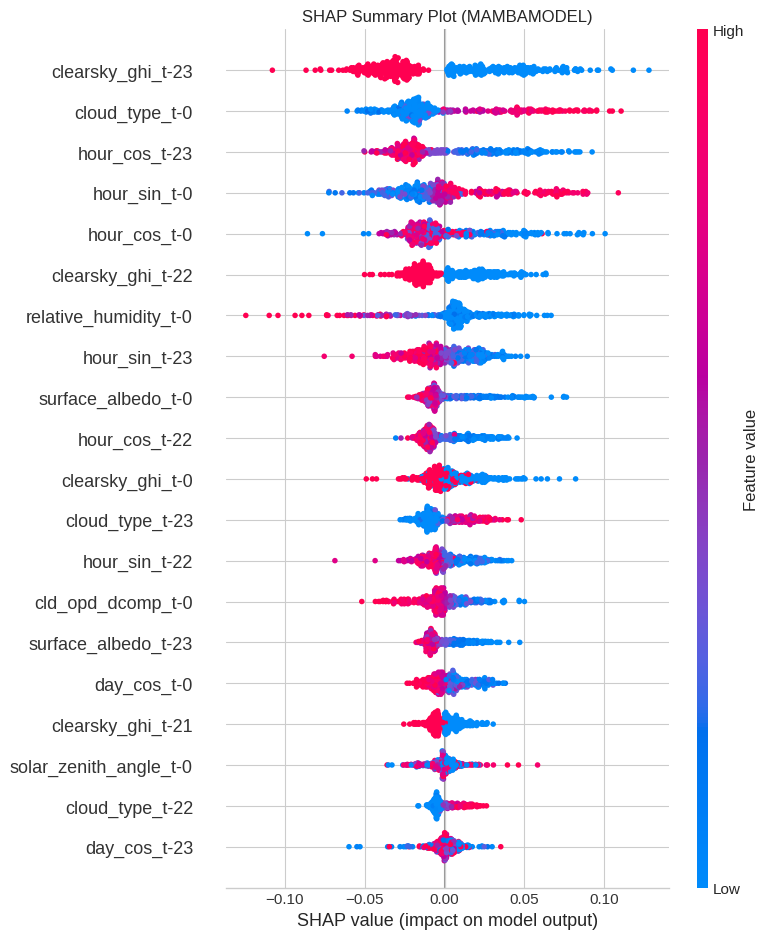

Summary plot saved to explainability/MambaModel_shap_summary_20250514_005954.png


In [31]:
# Plot SHAP Summary Plot
print("Generating SHAP summary plot...")
plt.figure()

# Ensure shap_values and X_flat match in dimensions and are properly shaped for summary_plot
# If we get multi-dimensional arrays, we need to flatten them correctly
if len(shap_values_for_viz.shape) > 2:
    print(f"Reshaping multi-dimensional SHAP values from {shap_values_for_viz.shape} to 2D")
    shap_values_for_viz = shap_values_for_viz.reshape(shap_values_for_viz.shape[0], -1)

if len(X_flat_for_viz.shape) > 2:
    print(f"Reshaping multi-dimensional X_flat from {X_flat_for_viz.shape} to 2D")
    X_flat_for_viz = X_flat_for_viz.reshape(X_flat_for_viz.shape[0], -1)

# Check if dimensions match
if shap_values_for_viz.shape[1] != X_flat_for_viz.shape[1]:
    print(f"Warning: Mismatch between SHAP values shape {shap_values_for_viz.shape} and feature shape {X_flat_for_viz.shape}")
    # Adjust feature dimensions if needed
    min_dim = min(shap_values_for_viz.shape[1], X_flat_for_viz.shape[1])
    shap_values_for_viz = shap_values_for_viz[:, :min_dim]
    X_flat_for_viz = X_flat_for_viz[:, :min_dim]
    feature_names_flat = feature_names_flat[:min_dim]

print(f"Final shapes - SHAP values: {shap_values_for_viz.shape}, X_flat: {X_flat_for_viz.shape}, feature names: {len(feature_names_flat)}")

shap.summary_plot(
    shap_values_for_viz,
    X_flat_for_viz,
    feature_names=feature_names_flat,
    max_display=20,
    show=False
)
plt.title(f'SHAP Summary Plot ({model_type.upper()})')
plt.tight_layout()
summary_plot_path = output_dir / f"{model_type}_shap_summary_{timestamp}.png"
plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"Summary plot saved to {summary_plot_path}")


### 6.8 SHAP Explanation - Waterfall Plot for Individual Predictions (High and Mid)
In this section, we will create a waterfall plot for a single instance with the highest prediction value and a mid-range prediction value.

Generating SHAP waterfall plots...
Selected instance 199 with highest predicted value: 0.9734980463981628
Selected instance 278 with mid-range predicted value: 0.015551269054412842
Base value for waterfall plot: 0.2016017735004425


<Figure size 1200x1000 with 0 Axes>

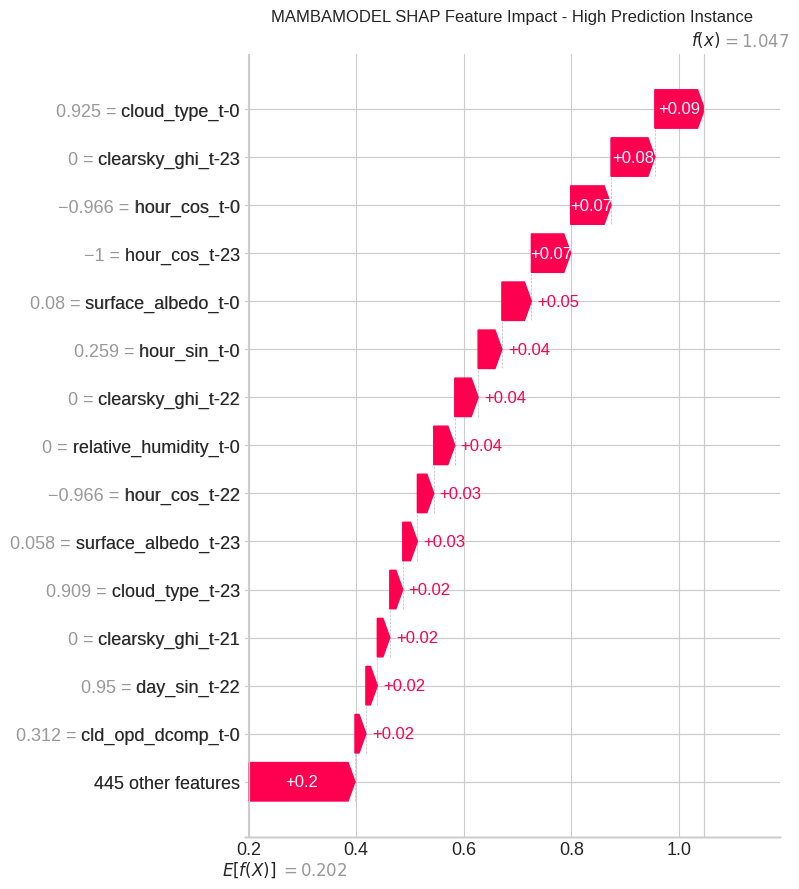

<Figure size 1200x1000 with 0 Axes>

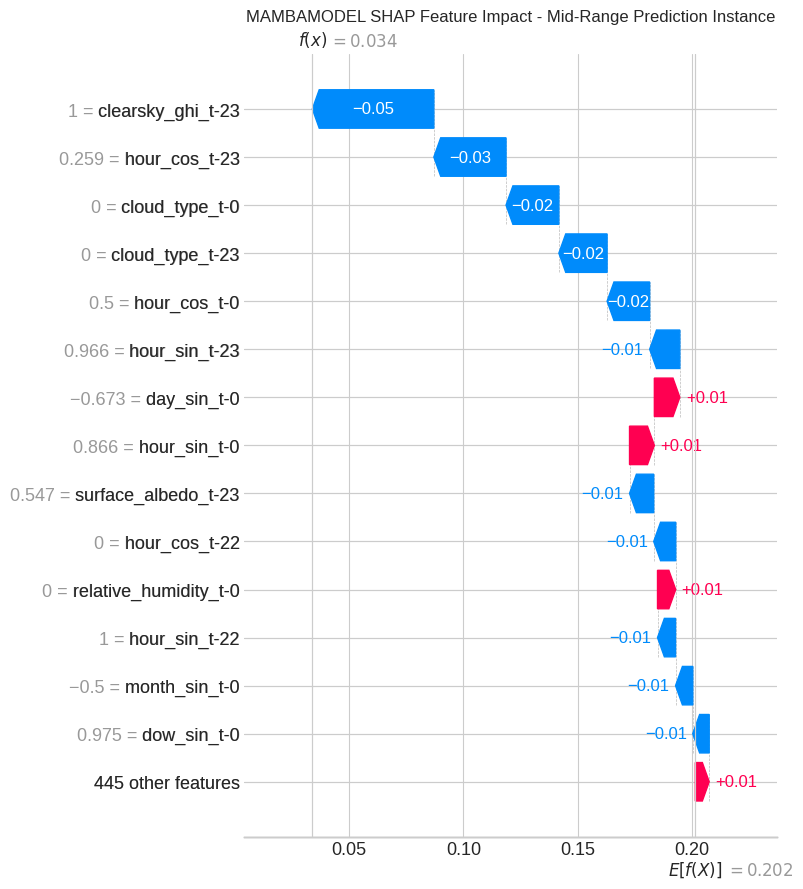

Waterfall plots saved to explainability/MambaModel_waterfall_high_20250514_005954.png and explainability/MambaModel_waterfall_mid_20250514_005954.png


In [32]:
# Waterfall plot shows feature impact for a single instance
print("Generating SHAP waterfall plots...")

# Select a representative instance to explain (pick one with high prediction value)
# Run model prediction on all samples to find interesting cases
X_temp_tensor = torch.tensor(X_temporal_explain, dtype=torch.float32).to(device)
X_static_tensor = torch.tensor(X_static_explain, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions = model(X_temp_tensor, X_static_tensor).cpu().numpy()

# Find instance with highest prediction value (most interesting case)
high_idx = np.argmax(predictions)
print(f"Selected instance {high_idx} with highest predicted value: {predictions[high_idx]}")

# For comparison, also find a mid-range prediction
mid_idx = np.argsort(predictions.flatten())[len(predictions)//2]
print(f"Selected instance {mid_idx} with mid-range predicted value: {predictions[mid_idx]}")

# Create waterfall plot for high prediction instance
plt.figure(figsize=(12, 10))
# The waterfall plot requires a single instance of SHAP values
shap_values_high = shap_values_for_viz[high_idx]
feature_names_for_plot = feature_names_flat

# Prepare expected values (base value)
expected_value = explainer.get_expected_value(background_data=X_combined_bg)

print(f"Base value for waterfall plot: {expected_value}")

# Create a matplotlib figure to control size and save
plt.figure(figsize=(14, 10))

# Create a SHAP Explanation object for the waterfall plot
# This is necessary because waterfall() expects an Explanation object
explanation = shap.Explanation(
    values=shap_values_high,
    base_values=expected_value,
    data=X_flat_for_viz[high_idx],
    feature_names=feature_names_for_plot
)

# Draw the waterfall plot with the Explanation object
shap.plots.waterfall(
    explanation,
    max_display=15,  # Limit to top features
    show=False
)
plt.title(f"{model_type.upper()} SHAP Feature Impact - High Prediction Instance")
plt.tight_layout()

# Save the waterfall plot
waterfall_high_path = output_dir / f"{model_type}_waterfall_high_{timestamp}.png"
plt.savefig(waterfall_high_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Create waterfall plot for mid-range prediction instance
plt.figure(figsize=(12, 10))
shap_values_mid = shap_values_for_viz[mid_idx]

# Create an Explanation object for the mid-range prediction
explanation_mid = shap.Explanation(
    values=shap_values_mid,
    base_values=expected_value,
    data=X_flat_for_viz[mid_idx],
    feature_names=feature_names_for_plot
)

# Draw the waterfall plot for mid-range instance
plt.figure(figsize=(14, 10))
shap.plots.waterfall(
    explanation_mid,
    max_display=15,  # Limit to top features
    show=False
)
plt.title(f"{model_type.upper()} SHAP Feature Impact - Mid-Range Prediction Instance")
plt.tight_layout()

# Save the waterfall plot
waterfall_mid_path = output_dir / f"{model_type}_waterfall_mid_{timestamp}.png"
plt.savefig(waterfall_mid_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"Waterfall plots saved to {waterfall_high_path} and {waterfall_mid_path}")


### 6.9 SHAP Explanation - Temporal Analysis on Time Steps
In this section, we will create a temporal analysis plot for the SHAP values.

Generating temporal analysis plots...
Temporal importance shape: (24, 19), should be (24, 19)


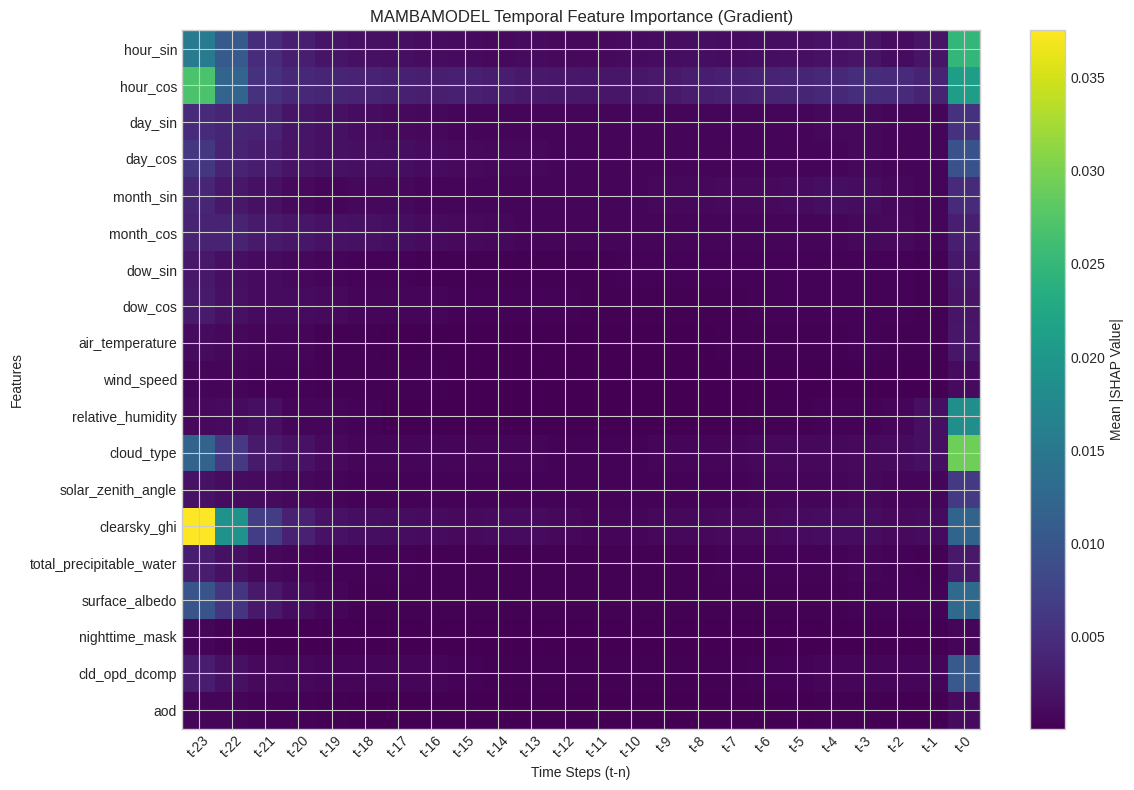

Temporal analysis plot saved to explainability/MambaModel_gradient_temporal_importance_20250514_005954.png
Feature average importance shape: (19,)
Top 10 feature indices: [10  4  5  2 15  3 11  0 13  1]
Feature 'relative_humidity' importance shape: (24,)
Feature 'month_sin' importance shape: (24,)
Feature 'month_cos' importance shape: (24,)
Feature 'day_sin' importance shape: (24,)
Feature 'surface_albedo' importance shape: (24,)
Feature 'day_cos' importance shape: (24,)
Feature 'cloud_type' importance shape: (24,)
Feature 'hour_sin' importance shape: (24,)
Feature 'clearsky_ghi' importance shape: (24,)
Feature 'hour_cos' importance shape: (24,)


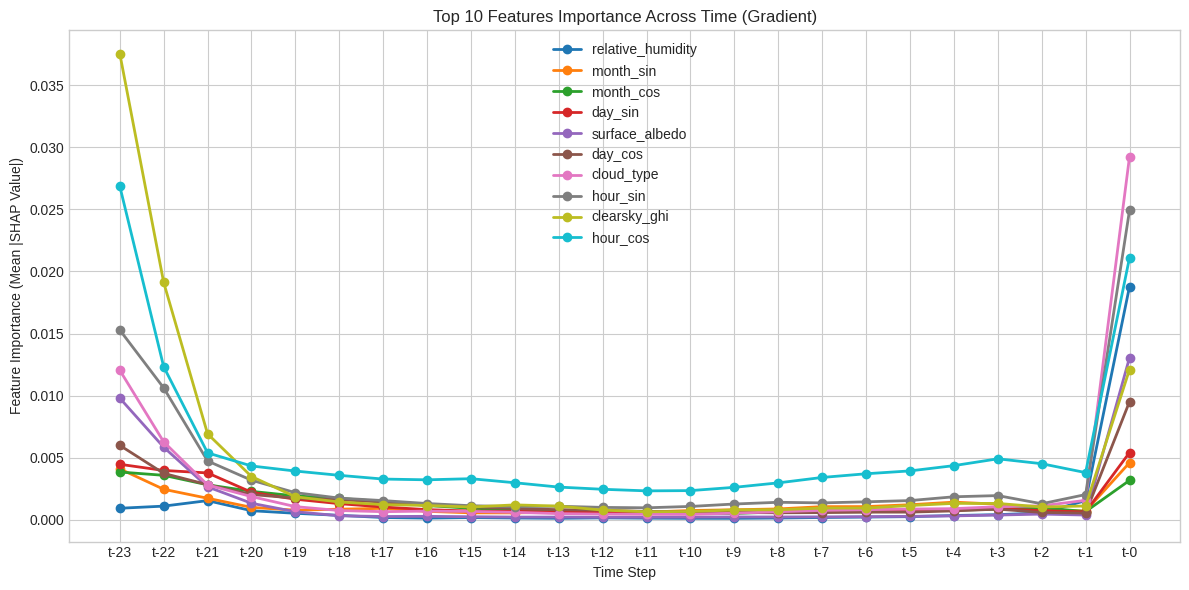

Top features temporal analysis saved to explainability/MambaModel_gradient_top_features_temporal_20250514_005954.png


In [33]:
# Generate temporal visualization if we have 3D data (either from gradient or reshaped kernel)
print("Generating temporal analysis plots...")

# Calculate feature importance across time steps
batch_size, seq_len, n_features = shap_values_3d.shape
temporal_importance = np.abs(shap_values_3d).mean(axis=0)  # Shape: (seq_len, n_features)
print(f"Temporal importance shape: {temporal_importance.shape}, should be ({seq_len}, {n_features})")

# Create a plot showing feature importance across time steps
plt.figure(figsize=(12, 8))

# Create a heatmap of temporal importance
plt.imshow(temporal_importance.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Mean |SHAP Value|')

# Set axis labels and ticks
plt.xlabel('Time Steps (t-n)')
plt.ylabel('Features')
# X-axis ticks are time steps from past to present
time_labels = [f't-{seq_len-1-i}' for i in range(seq_len)]
plt.xticks(range(seq_len), time_labels, rotation=45)
# Y-axis ticks are feature names
plt.yticks(range(n_features), temporal_features)

plt.title(f'{model_type.upper()} Temporal Feature Importance ({SHAP_ALGORITHM.capitalize()})')
plt.tight_layout()

# Save the plot
temporal_plot_path = output_dir / f"{model_type}_{SHAP_ALGORITHM}_temporal_importance_{timestamp}.png"
plt.savefig(temporal_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"Temporal analysis plot saved to {temporal_plot_path}")

# Create line plots for top features across time
# Identify top N features based on overall importance
top_n = min(10, n_features)
# Calculate mean importance per feature across all time steps
feature_avg_importance = np.mean(temporal_importance, axis=0)  # Shape: (n_features,)
print(f"Feature average importance shape: {feature_avg_importance.shape}")
# Get indices of top N features by importance
top_features_idx = np.argsort(feature_avg_importance)[-top_n:]
print(f"Top {top_n} feature indices: {top_features_idx}")

plt.figure(figsize=(12, 6))

# Create x-axis values for plotting - using integers from 0 to seq_len-1
x_values = np.arange(seq_len)

# Plot each top feature's importance over time
for i, feat_idx in enumerate(top_features_idx):
    feat_name = temporal_features[feat_idx]
    # Extract this feature's importance at each time step
    importance_over_time = temporal_importance[:, feat_idx]
    print(f"Feature '{feat_name}' importance shape: {importance_over_time.shape}")
    # Plot this feature's line
    plt.plot(x_values, importance_over_time, marker='o', linewidth=2, label=feat_name)

plt.xlabel('Time Step')
plt.ylabel('Feature Importance (Mean |SHAP Value|)')
plt.title(f'Top {top_n} Features Importance Across Time ({SHAP_ALGORITHM.capitalize()})')
plt.xticks(x_values, time_labels)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
top_features_path = output_dir / f"{model_type}_{SHAP_ALGORITHM}_top_features_temporal_{timestamp}.png"
plt.savefig(top_features_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"Top features temporal analysis saved to {top_features_path}")


### 7. Sensitivity Analysis (Alternative to SHAP Gradient)
This is a custom analysis that is not based on SHAP.
It is a simple sensitivity analysis that alters the values of input features and measures the impact on the prediction.
It treats each feature as a whole, not taking lookback window into account so we can have a plot of global feature importance.

--- Running Sensitivity Analysis ---
Sensitivity analysis complete.
Generating feature sensitivity plot...


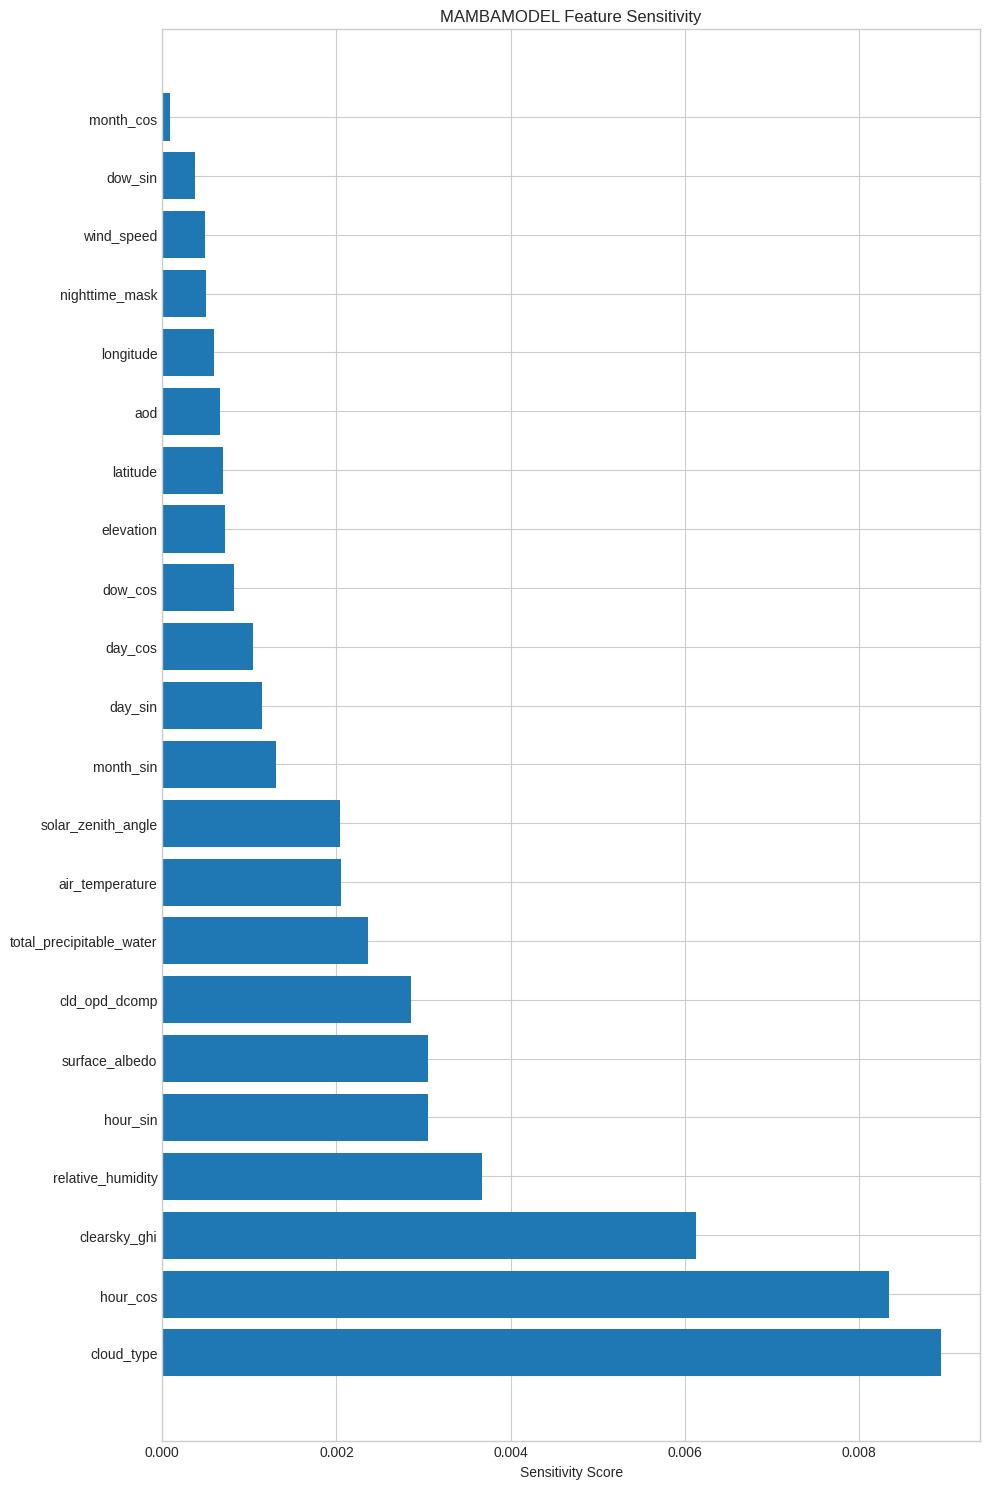

Feature sensitivity plot saved to explainability/MambaModel_sensitivity.png
Sensitivity data saved to explainability/MambaModel_sensitivity.csv
Top 10 Features by Sensitivity:
                     Feature  Sensitivity
11                cloud_type     0.008945
1                   hour_cos     0.008347
13              clearsky_ghi     0.006131
10         relative_humidity     0.003669
0                   hour_sin     0.003054
15            surface_albedo     0.003049
17             cld_opd_dcomp     0.002858
14  total_precipitable_water     0.002368
8            air_temperature     0.002056
12        solar_zenith_angle     0.002037


In [34]:
print("--- Running Sensitivity Analysis ---")
model.eval()
# Initialize the sensitivity analyzer
sa_explainer = SensitivityAnalyzer(model, temporal_features, static_features)

# Analyze feature sensitivity
sensitivity_df = sa_explainer.analyze_feature_sensitivity(
    X_temporal_array,
    X_static_array,
    perturbation=0.1, # How much to perturb features
    n_samples=min(10, X_temporal_array.shape[0]) # Number of samples to base analysis on
)
print("Sensitivity analysis complete.")

# Plot feature sensitivity
print("Generating feature sensitivity plot...")
fig = sa_explainer.plot_feature_sensitivity(
    sensitivity_df,
    max_display=50,
    show=False,
    title=f"{model_type.upper()} Feature Sensitivity"
)
sensitivity_plot_path = output_dir / f"{model_type}_sensitivity.png"
fig.savefig(sensitivity_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)
print(f"Feature sensitivity plot saved to {sensitivity_plot_path}")

# Save sensitivity data
sensitivity_csv_path = output_dir / f"{model_type}_sensitivity.csv"
sensitivity_df.to_csv(sensitivity_csv_path, index=False)
print(f"Sensitivity data saved to {sensitivity_csv_path}")
print("Top 10 Features by Sensitivity:")
print(sensitivity_df.head(10))
